In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import pathlib

from datetime import datetime, time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from ipywidgets import IntProgress
from IPython.display import display
import time


In [2]:
max_count_progress = 100

In [3]:
BASE_DIR = pathlib.Path().cwd()

In [4]:
df = pd.read_csv('base_table.csv', parse_dates= ['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime'])

In [5]:
def preprocess_conversation(conversation):
    # Split the conversation into individual messages
    messages = conversation.split('\n')

    # returning only the lines which have the :
    return [msg.split(': ', 1) for msg in messages if ': ' in msg]

In [6]:
def extract_problem(messages):
    # Assume the Customer says the problem
    problem_desc = ""

    # the idea is that the problem should be fully described in at most ~ 6 dialogues, ie, ~ 3 customer messages
    for person, text in messages[:6]:
        if 'customer' in person.lower():
            problem_desc += ". " +  text
    return problem_desc

In [7]:
def calculate_satisfaction_score(df):
    sia = SentimentIntensityAnalyzer()
    vectorizer = TfidfVectorizer()

    
    results = []
    call_ids_bad = []

    dflen = len(df)
    
    f = IntProgress(min=0, max=max_count_progress) # instantiate the bar
    display(f) # display the bar    

    c = 0
    for index, row in df.iterrows():
        conversation = row['call_transcript']
        messages = preprocess_conversation(conversation)
        problem = extract_problem(messages)
        
        if problem is None:
            results.append(0.0)
            continue
        
        # Analyze sentiment change for customer
        customer_sentiments = [sia.polarity_scores(text)['compound'] for person, text in messages if person.lower() == 'customer']
        sentiment_change = customer_sentiments[-1] - customer_sentiments[0] if len(customer_sentiments) > 1 else 0
        normalized_sentiment_change = (sentiment_change + 2) / 4  # Normalize from [-2, 2] to [0, 1]
        
        # Analyze content similarity between problem and final messages
        all_texts = [text for _, text in messages]

        try:
            tfidf_matrix = vectorizer.fit_transform(all_texts)
        except:
            call_ids_bad.append(row['call_id'])
            results.append(0.5)
            continue
            
        # assume last 3 messages are the conclusion messages
        final_messages_vector = tfidf_matrix[-3:]
        
        # assume first 3 messages are the problem messages
        try:
            problem_vector = tfidf_matrix[[1, 3, 5], :]
        except IndexError:
            try:
                problem_vector = tfidf_matrix[[1, 3], :] 
            except IndexError:
                try:
                    problem_vector = tfidf_matrix[[1], :] 
                except IndexError:
                    # there is nothing we can do
                    call_ids_bad.append(row['call_id'])
                    results.append(0.5)
                    continue
        
        similarities = cosine_similarity(problem_vector, final_messages_vector)
        content_relevance = similarities.mean()

        # Check for positive keywords in agent's final message
        agent_final_words = [text for person, text in messages[-6:] if person.lower() == 'agent'][-3:]
        positive_keywords = ['solved', 'fixed', 'resolved', 'solution', 'helped', 'understand', 'clear', 'thank', 'care', 'welcome', 'happy', 'safe']
        
        keyword_count = sum(
                    keyword in text.lower() 
                    for text in agent_final_words 
                    for keyword in positive_keywords
                )
        normalized_keyword_score = min(keyword_count / 5, 1)
        
        # Calculate final satisfaction score
        satisfaction_score = (
            0.4 * normalized_sentiment_change +
            0.2 * content_relevance +
            0.4 * normalized_keyword_score
        )
        satisfaction_score_result = min(max(satisfaction_score, 0), 1)
        results.append(satisfaction_score_result)  # Ensure score is between 0 and 1
        f.value = (c / dflen) * 100
        c += 1
    
    return results, call_ids_bad

In [8]:
satscores = BASE_DIR / 'satisfaction_scores.csv'
if not satscores.exists():
    df['satisfaction_score'], call_ids_bad = calculate_satisfaction_score(df)
    call_ids_bad
    print(len(df))
    df = df[~df['call_id'].isin(call_ids_bad)]
    print("after removing nonsyntactical convos: ", len(df))
    call_satisfaction = df[['call_id', 'satisfaction_score']]
    call_satisfaction.to_csv('satisfaction_scores.csv', index= False)
else:
    # it already exists, get call ids from there
    satscores = pd.read_csv('./satisfaction_scores.csv')
    df =  df.merge(satscores[['call_id', 'satisfaction_score']], how= 'left', on= 'call_id')

In [9]:
# now calculate the correlation matrix
correlation_matrix = df[['handle_time', 'satisfaction_score', 'speed_to_answer', 'elite_level_code', 'silence_percent_average', 'agent_tone', 'customer_tone']].corr()

correlation_matrix

,handle_time,satisfaction_score,speed_to_answer,elite_level_code,silence_percent_average,agent_tone,customer_tone
handle_time,1.000000,0.020228,0.165169,0.034904,0.399125,0.021405,0.000251
satisfaction_score,0.020228,1.000000,0.000678,-0.000794,0.014287,0.028578,0.212505
speed_to_answer,0.165169,0.000678,1.000000,-0.043335,-0.012068,-0.034015,-0.000728
elite_level_code,0.034904,-0.000794,-0.043335,1.000000,-0.010261,-0.006950,-0.002757
silence_percent_average,0.399125,0.014287,-0.012068,-0.010261,1.000000,-0.043927,0.000716
agent_tone,0.021405,0.028578,-0.034015,-0.006950,-0.043927,1.000000,0.002283
customer_tone,0.000251,0.212505,-0.000728,-0.002757,0.000716,0.002283,1.000000


In [10]:
print(df['handle_time'].mean())

1134.1161398133966


In [11]:
avg_tta = df['speed_to_answer'].mean()
std_tta = df['speed_to_answer'].std()

# the calls which were answered early (1.7 * sigma early) than the average
early_picked_calls = df[df['speed_to_answer'] < avg_tta - 1.7 * std_tta]


print(early_picked_calls['handle_time'].mean())
print(early_picked_calls['satisfaction_score'].mean())

809.4028436018957
0.5560685632674932


# Inference from the Early Picked Calls
- It is clearly visible that satisfaction score of Early Picked Calls is > 0.5
- So, a suggestion would be to double down on picking up calls early (decreasing AST), by using the methods described in the other notebooks

<Axes: xlabel='handle_time', ylabel='speed_to_answer'>

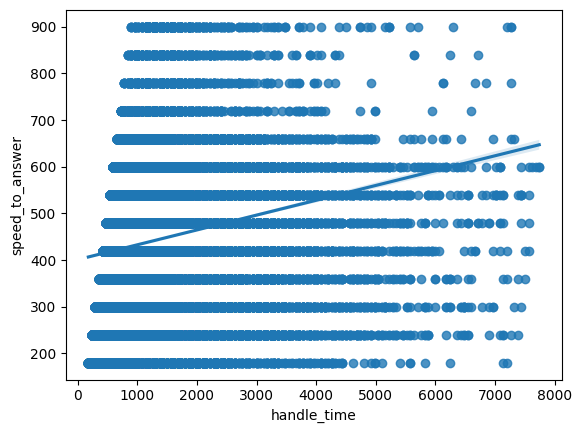

In [12]:
sns.regplot(x= df['handle_time'], y= df['speed_to_answer'])

# For the AHT-AST correlation
- AHT and AST seem to go hand in hand
- So, another suggestion would be to decreasing pick calls early so that the customer's problems get solved quicker

# Inference for satisfaction scores
- Handle Time is increasing with satisfaction score, so, advice is to keep the customer indulged
    so that the customer feels attended to
- Elite Level Code is decreasing with increase in satisfaction score, so, the best agents must be alloted with
    least workload to increase satisfaction score

In [13]:
unique_sentiments = np.array(['neutral', 'frustrated', 'calm', 'angry', np.nan, 'polite'], dtype=object)

In [14]:
tone_convert = dict(zip(unique_sentiments, [0, 2, -1, 1, 0.001, -2]))
tone_convert_back = {v: k for k, v in tone_convert.items()}

In [15]:
tone_convert_back

{0: 'neutral',
 2: 'frustrated',
 -1: 'calm',
 1: 'angry',
 0.001: nan,
 -2: 'polite'}

In [16]:
df['agent_tone'] = df['agent_tone'].apply(lambda x: tone_convert_back[x])
df['customer_tone'] = df['customer_tone'].apply(lambda x: tone_convert_back[x])
df.drop(columns = ['Unnamed: 0'])

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,handle_time,speed_to_answer,satisfaction_score
0,131642,103262588,132311,2024-08-04 17:46:00,2024-08-04 17:55:00,2024-08-04 17:59:00,\n\nAgent: Thank you for calling United Airlin...,Michael Petersen,0.0,Seating,neutral,polite,-0.07,0.03,780.0,540.0,0.652593
1,325527,8994245383,607742,2024-08-18 07:41:00,2024-08-18 07:45:00,2024-08-18 07:50:00,\n\nAgent: Thank you for calling United Airlin...,Andrew Hess,-1.0,IRROPS,neutral,angry,-0.19,0.05,540.0,240.0,0.580880
2,526871,5769982111,748700,2024-08-10 11:59:00,2024-08-10 12:08:00,2024-08-10 12:15:00,\n\nAgent: Thank you for calling United Airlin...,Joseph Thomas,3.0,Voluntary Change,neutral,frustrated,-0.22,0.13,960.0,540.0,0.618597
3,634548,9534089270,542034,2024-08-11 11:15:00,2024-08-11 11:25:00,2024-08-11 11:39:00,\n\nAgent: Thank you for calling United Airlin...,Victoria Green,0.0,Seating,neutral,polite,-0.11,0.24,1440.0,600.0,0.614585
4,693921,3046806067,633922,2024-08-06 15:58:00,2024-08-06 16:09:00,2024-08-06 16:15:00,\n\nAgent: Thank you for calling United Airlin...,Vickie Lopez,1.0,Voluntary Change,neutral,frustrated,-0.02,0.14,1020.0,660.0,0.647014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71805,9999337789,915905859,418648,2024-08-21 23:08:00,2024-08-21 23:17:00,2024-08-21 23:24:00,\n\nAgent: Thank you for calling United Airlin...,Jose Black,-1.0,NaN,neutral,neutral,-0.05,0.15,960.0,540.0,0.324851
71806,9999524523,3888680689,901589,2024-08-20 17:30:00,2024-08-20 17:36:00,2024-08-20 17:39:00,\n\nAgent: Thank you for calling United Airlin...,Angela Johnson,1.0,IRROPS,neutral,calm,-0.05,0.21,540.0,360.0,0.587504
71807,9999623753,4101455140,835105,2024-08-03 14:07:00,2024-08-03 14:11:00,2024-08-03 14:28:00,\n\nAgent: Thank you for calling United Airlin...,Michael Reed,-1.0,IRROPS,neutral,neutral,-0.17,0.40,1260.0,240.0,0.334502
71808,9999669038,3173856584,819946,2024-08-19 12:50:00,2024-08-19 12:55:00,2024-08-19 13:35:00,\n\nAgent: Thank you for calling United Airlin...,Marvin White,3.0,Mileage Plus,calm,angry,0.07,0.52,2700.0,300.0,0.417428


In [17]:
df

,Unnamed: 0,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,handle_time,speed_to_answer,satisfaction_score
0,0,131642,103262588,132311,2024-08-04 17:46:00,2024-08-04 17:55:00,2024-08-04 17:59:00,\n\nAgent: Thank you for calling United Airlin...,Michael Petersen,0.0,Seating,neutral,polite,-0.07,0.03,780.0,540.0,0.652593
1,1,325527,8994245383,607742,2024-08-18 07:41:00,2024-08-18 07:45:00,2024-08-18 07:50:00,\n\nAgent: Thank you for calling United Airlin...,Andrew Hess,-1.0,IRROPS,neutral,angry,-0.19,0.05,540.0,240.0,0.580880
2,2,526871,5769982111,748700,2024-08-10 11:59:00,2024-08-10 12:08:00,2024-08-10 12:15:00,\n\nAgent: Thank you for calling United Airlin...,Joseph Thomas,3.0,Voluntary Change,neutral,frustrated,-0.22,0.13,960.0,540.0,0.618597
3,3,634548,9534089270,542034,2024-08-11 11:15:00,2024-08-11 11:25:00,2024-08-11 11:39:00,\n\nAgent: Thank you for calling United Airlin...,Victoria Green,0.0,Seating,neutral,polite,-0.11,0.24,1440.0,600.0,0.614585
4,4,693921,3046806067,633922,2024-08-06 15:58:00,2024-08-06 16:09:00,2024-08-06 16:15:00,\n\nAgent: Thank you for calling United Airlin...,Vickie Lopez,1.0,Voluntary Change,neutral,frustrated,-0.02,0.14,1020.0,660.0,0.647014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71805,71805,9999337789,915905859,418648,2024-08-21 23:08:00,2024-08-21 23:17:00,2024-08-21 23:24:00,\n\nAgent: Thank you for calling United Airlin...,Jose Black,-1.0,NaN,neutral,neutral,-0.05,0.15,960.0,540.0,0.324851
71806,71806,9999524523,3888680689,901589,2024-08-20 17:30:00,2024-08-20 17:36:00,2024-08-20 17:39:00,\n\nAgent: Thank you for calling United Airlin...,Angela Johnson,1.0,IRROPS,neutral,calm,-0.05,0.21,540.0,360.0,0.587504
71807,71807,9999623753,4101455140,835105,2024-08-03 14:07:00,2024-08-03 14:11:00,2024-08-03 14:28:00,\n\nAgent: Thank you for calling United Airlin...,Michael Reed,-1.0,IRROPS,neutral,neutral,-0.17,0.40,1260.0,240.0,0.334502
71808,71808,9999669038,3173856584,819946,2024-08-19 12:50:00,2024-08-19 12:55:00,2024-08-19 13:35:00,\n\nAgent: Thank you for calling United Airlin...,Marvin White,3.0,Mileage Plus,calm,angry,0.07,0.52,2700.0,300.0,0.417428
